In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('/content/drive/MyDrive/PTDL/VCB.csv')
#df1=df.reset_index()['Price']
df=df.reset_index()['Price']
df

0       43216
1       44960
2       44429
3       44808
4       44505
        ...  
1237    91700
1238    92600
1239    92800
1240    95000
1241    94200
Name: Price, Length: 1242, dtype: int64

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 17s 117ms/step - loss: 0.0487 - val_loss: 0.0337
Epoch 2/100
12/12 [==============================] - 0s 25ms/step - loss: 0.0118 - val_loss: 0.0060
Epoch 3/100
12/12 [==============================] - 0s 21ms/step - loss: 0.0060 - val_loss: 0.0047
Epoch 4/100
12/12 [==============================] - 0s 23ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 5/100
12/12 [==============================] - 0s 21ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 6/100
12/12 [==============================] - 0s 25ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 7/100
12/12 [==============================] - 0s 24ms/step - loss: 0.0033 - val_loss: 0.0046
Epoch 8/100
12/12 [==============================] - 0s 26ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 9/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 10/100
12/12 [==============================] - 0s 23ms/step - loss: 0.0030 - val_loss: 0.00

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 25ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
train_size1 = int(0.7 * len(df))
test_size1 = int(0.2 * len(df))

train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)

In [13]:
# 12. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 6836.710782251641
Testing RMSE: 7393.76467272307
Validation MAPE: 6.281927878350246
Testing MAPE: 7.311379791746078
Validation MAE: 5162.7231875
Testing MAE: 5797.284521280791


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=65
i=0
while(i<30):

    if(len(temp_input)>65):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.96275485]
66
1 day input [0.93704202 0.94753502 0.96152568 0.96852101 0.94753502 0.95278152
 0.95627918 0.94403736 0.95627918 0.94753502 0.95103269 0.91080953
 0.91255837 0.92829786 0.93354436 0.94753502 0.93179553 0.92130253
 0.91255837 0.9195537  0.91255837 0.87758171 0.80937724 0.8338609
 0.87758171 0.90731187 0.87758171 0.91255837 0.92654903 0.93529319
 0.94228852 0.9195537  0.94403736 0.93004669 0.93179553 0.91605603
 0.89507004 0.87758171 0.86359105 0.86533989 0.86359105 0.86708872
 0.86708872 0.86009339 0.86883755 0.86533989 0.85134922 0.85834456
 0.86533989 0.88457704 0.89507004 0.9038142  0.86883755 0.89157238
 0.94753502 0.93529319 0.93004669 0.91255837 0.94403736 0.9248002
 0.94053969 0.94403736 0.98251167 0.96852101 0.96275485]
1 day output [[0.9548135]]
2 day input [0.94753502 0.96152568 0.96852101 0.94753502 0.95278152 0.95627918
 0.94403736 0.95627918 0.94753502 0.95103269 0.91080953 0.91255837
 0.92829786 0.93354436 0.94753502 0.93179553 0.92130253 0.91255837
 0.9195

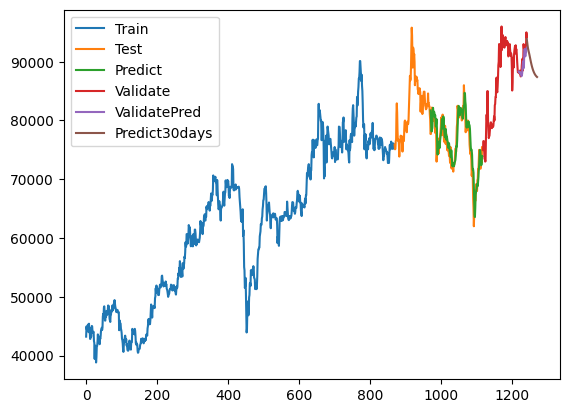

In [15]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()